# <center>Performances et optimisation de métaheuristique<br /> Workshop</center>

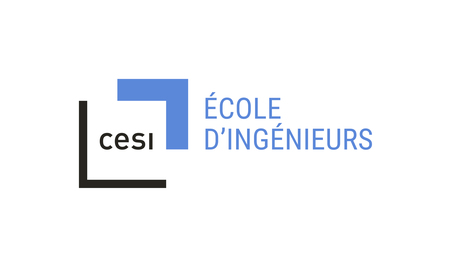


# 1. Introduction
Nous reprenons pour la dernière fois le problème du [sac à dos](https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_sac_%C3%A0_dos), et on va chercher à savoir si les algorithmes qu'on a conçus sont efficaces


Commencez par intégrer le code de la recherche tabou que vous avez conçue la dernière fois.

In [18]:
from collections import deque
import random
from functools import lru_cache

def random_objets(poids_max, val_max):
    """
    Cette fonction génère des objets de poids et de valeur
    aléatoires (bornés par les valeurs passées en parametre).
    Renvoie un tuple de 2 dictionnaires (poids,valeur)
    """
    poids_objets = {i: random.randint(1, poids_max) for i in range(nb_objets)}
    valeur_objets = {i: random.randint(1, val_max) for i in range(nb_objets)}
    return poids_objets, valeur_objets

def random_solution():
    sac = tuple(random.choice([False, True]) for _ in range(nb_objets))

    while (poids_contenu(sac) > capacite):
        objets_presents = tuple(i for i, val in enumerate(sac) if val)
        objet_supprime = random.choice(objets_presents)
        sac = sac[:objet_supprime] + (False,) + sac[objet_supprime+1:]
    return sac

@lru_cache(maxsize=None)
def poids_contenu(sac):
    """
    Cette fonction renvoie la somme des poids des objets dans le sac
    """
    return sum([poids_objets[i] for i, val in enumerate(sac) if val])

@lru_cache(maxsize=None)
def valeur_contenu(sac):
    """
    Cette fonction renvoie la somme des valeurs des objets dans le sac
    """
    return sum([valeur_objets[i] for i, val in enumerate(sac) if val])

@lru_cache(maxsize=None)
def voisinage(sac):
    voisins = []
    for k in range(len(sac)):
        voisin = sac[:k] + (not sac[k],) + sac[k+1:]
        if poids_contenu(voisin) <= capacite:
            voisins.append(voisin)
    return voisins

def recherche_tabou(solution_initiale, taille_tabou, iter_max):
    """
    1. On part d'un élément de notre ensemble de recherche qu'on déclare élément courant
    2. On considère le voisinage de l'element courant et on choisit le  meilleur d'entre
       eux comme nouvel element courant, parmi ceux absents de la liste tabou, et on l'ajoute
       a la liste tabou
    3. On boucle jusqu'a condition de sortie.
    """
    nb_iter = 0
    liste_tabou = deque(maxlen=taille_tabou)

    # variables solutions pour la recherche du voisin optimal non tabou
    solution_courante = solution_initiale
    meilleure = solution_initiale
    meilleure_globale = solution_initiale

    # variables valeurs pour la recherche du voisin optimal non tabou
    valeur_meilleure = valeur_contenu(solution_initiale)
    valeur_meilleure_globale = valeur_meilleure

    
    while (nb_iter < iter_max):
        valeur_meilleure = -1
        
        # on parcourt tous les voisins de la solution courante
        for voisin in voisinage(solution_courante):
            valeur_voisin = valeur_contenu(voisin)
            if valeur_voisin > valeur_meilleure and voisin not in liste_tabou:
                meilleure = voisin
                valeur_meilleure = valeur_voisin

        # on met à jour la meilleure solution rencontrée depuis le debut
        if valeur_meilleure > valeur_meilleure_globale:
            meilleure_globale = meilleure
            valeur_meilleure_globale = valeur_meilleure
            nb_iter = 0
        else:
            nb_iter += 1

        # on passe au meilleur voisin non tabou trouvé
        solution_courante = meilleure

        # on met à jour la liste tabou
        liste_tabou.append(solution_courante)

    return meilleure_globale

Relançons notre méthode&nbsp;!

In [19]:
nb_objets = 100
capacite = 20
random.seed(a=3)
poids_objets, valeur_objets = random_objets(10, 10)
sac = (False,)*nb_objets

print("tabou de taille 5")
sol = recherche_tabou(sac, taille_tabou=5, iter_max=30)
print("valeur finale = " + str(valeur_contenu(sol)) + ", capacite="+str(poids_contenu(sol)) + "/" + str(capacite))
print([i for i, val in enumerate(sol) if val]) # composition de la solution

tabou de taille 5
valeur finale = 62, capacite=20/20
[24, 27, 30, 41, 44, 45, 62]


# 2. Comportement de l'algorithme

Avec notre algorithme, on obtient une solution réalisable, mais on ne sait pas vraiment comment l'algorithme l'a obtenue. Difficile dans ces conditions d'imaginer ce qu'on pourrait faire pour améliorer la solution obtenue. Essayons déjà de voir comment l'algorithme arrive à ce résultat.

## 2.1 Étude de la trajectoire

Commençons par étudier la trajectoire que suit notre algorithme. C'est assez simple, il suffit de retenir toutes les solutions courantes et l'historique des meilleures solutions trouvées à chaque itération, et d'afficher tout ça avec [matplotlib](https://matplotlib.org/index.html). Allons-y !



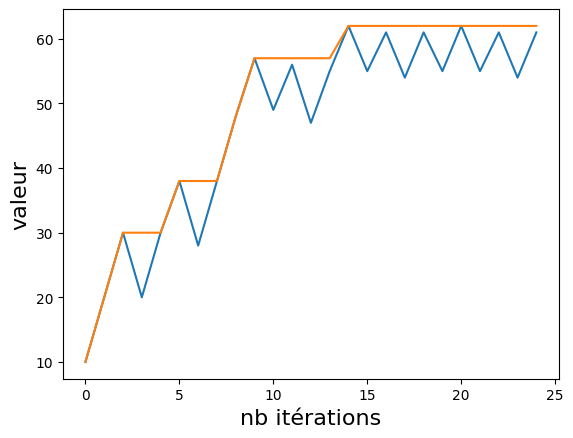

In [20]:
import matplotlib.pyplot as plt

def recherche_tabou_traject(solution_initiale, taille_tabou, iter_max):
    """
    1. On part d'un élément de notre ensemble de recherche qu'on déclare élément courant
    2. On considère le voisinage de l'élément courant, on choisit le meilleur d'entre
       eux comme nouvel élément courant parmi ceux absents de la liste tabou, et on l'ajoute
       à la liste tabou
    3. On boucle jusqu'à condition de sortie.
    """
    nb_iter = 0
    liste_tabou = deque((), maxlen = taille_tabou)

    # variables solutions pour la recherche du voisin optimal non tabou
    solution_courante = solution_initiale
    meilleure = solution_initiale
    meilleure_globale = solution_initiale

    # variables valeurs  pour la recherche du voisin optimal non tabou
    valeur_meilleure = valeur_contenu(solution_initiale)
    valeur_meilleure_globale = valeur_meilleure
    
    meilleure_tournee = 0
    meilleure_global_tournee = 0
    # liste des solutions courantes et des meilleures trouvées, pour afficher la trajectoire
    # l'élément à la ième position correspond à l'itération i
    courantes = deque()
    meilleures_courantes = deque()
    
    while (nb_iter < iter_max):
        nb_iter += 1
        valeur_meilleure = 0
        
        # on parcourt tous les voisins de la solution courante
        for voisin in voisinage(solution_courante):
            valeur_voisin = valeur_contenu(voisin)
            
            if valeur_voisin > valeur_meilleure and voisin not in liste_tabou:
                meilleure_tournee +=1
                valeur_meilleure = valeur_voisin
                meilleure = voisin

        # on met à jour la meilleure solution rencontrée depuis le début
        if valeur_meilleure > valeur_meilleure_globale:
            meilleure_globale = meilleure
            valeur_meilleure_globale = valeur_meilleure
            nb_iter = 0
            meilleure_global_tournee += 1
        
        meilleures_courantes.append(valeur_meilleure_globale)
                
        courantes.append(valeur_meilleure)
        
        # on passe au meilleur voisin non tabou trouvé
        solution_courante = meilleure
        
        # on met à jour la liste tabou
        liste_tabou.append(solution_courante)

    return meilleure_globale, courantes, meilleures_courantes

sac = (False,)*nb_objets
    
iter_max = 10
taille_tabou = 5
sol, courants, meilleurs_courants=recherche_tabou_traject(sac, taille_tabou, iter_max)

plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)
res = plt.plot(range(len(courants)), courants)
res = plt.plot(range(len(courants)), meilleurs_courants)

On observe un phénomène intéressant au bout d'un certain temps. Comment s'appelle-t-il&nbsp;? Comment l'interpréter, et que pourrions-nous faire face à ça&nbsp;?

<em>À COMPLÉTER</em>

Testons cette solution (avec une valeur de 200, par exemple)&nbsp;:

Text(0, 0.5, 'valeur')

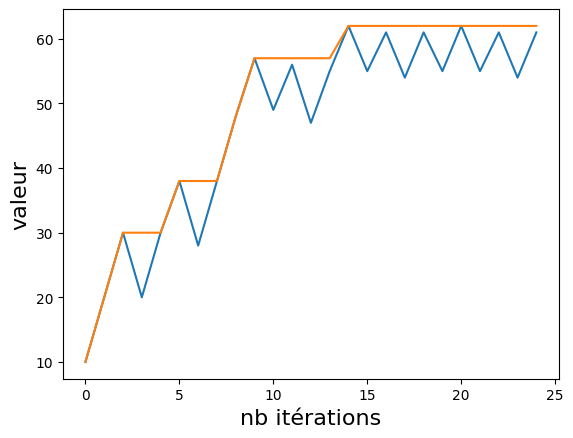

In [21]:
sac=(False,)*nb_objets
#À COMPLÉTER
sol, courants, meilleurs_courants=recherche_tabou_traject(sac, taille_tabou, iter_max)

plt.plot(range(len(courants)), courants)
plt.plot(range(len(courants)), meilleurs_courants)
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)

Comment interprétez-vous cette courbe&nbsp;?

<em>À COMPLÉTER</em>

Essayons donc d'augmenter encore la valeur.

Text(0, 0.5, 'valeur')

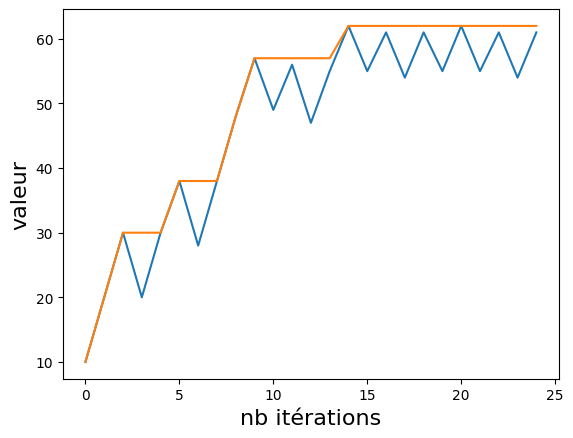

In [22]:
sac=(False,)*nb_objets
#À COMPLÉTER
sol, courants, meilleurs_courants=recherche_tabou_traject(sac, taille_tabou, iter_max)

plt.plot(range(len(courants)), courants)
plt.plot(range(len(courants)), meilleurs_courants)
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)

Qu'est-ce que ça donne ? Comment y remédier ?

<em>À COMPLÉTER</em>

Essayons avec la même valeur que pour la taille de la liste.

Text(0, 0.5, 'valeur')

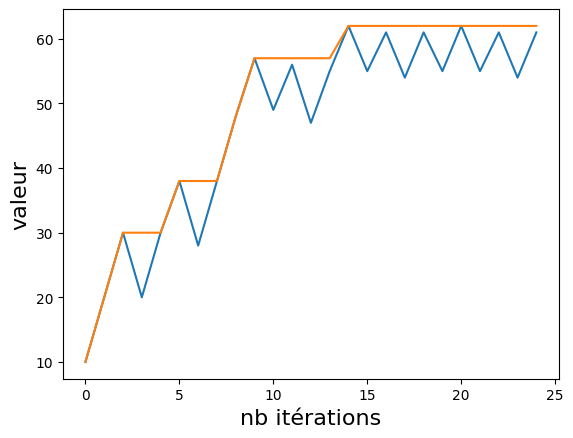

In [23]:
sac=(False,)*nb_objets
#À COMPLÉTER
sol, courants, meilleurs_courants=recherche_tabou_traject(sac, taille_tabou, iter_max)

plt.plot(range(len(courants)), courants)
plt.plot(range(len(courants)), meilleurs_courants)
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)

Qu'observe-t-on ?

<em>À COMPLÉTER</em>


## 2.2 Qualité de la solution

Mais finalement, on ne sait pas si cette solution que notre algorithme génère est vraiment bonne. On sait qu'on l'a améliorée depuis le Hill-Climbing, et qu'on peut faire mieux, puisque le multi-start y arrive. Or, la question risque d'être difficile à trancher. Pourquoi&nbsp;?

<em>À COMPLÉTER</em>

Mais on pourrait quand même essayer de trouver un point de comparaison, moins précis, mais qui nous apporte quand même quelques informations. Et la solution est en fait très simple, elle se retrouve dans le Workshop sur la programmation linéaire. Souvenez-vous, on avait déjà travaillé sur le problème du sac à dos. Est-ce qu'on avait réussi à le résoudre&nbsp;? Pourquoi&nbsp;?

<em>À COMPLÉTER</em>

Et que produisait la méthode de résolution qu'on avait essayé de mettre en place&nbsp;?

<em>À COMPLÉTER</em>

Le voilà notre indicateur&nbsp;! Grace à ça, on va pouvoir mettre en place un [plan d'expériences](https://fr.wikipedia.org/wiki/Plan_d%27exp%C3%A9riences) (inutile par contre d'appliquer directement les principes mathématiques mentionnés dans ce lien, ils sont juste là pour vous donner une idée du principe général et sont des outils rarement utilisés tel quel dans le domaine de l'évaluation d'algorithmes).


Une fois qu'on a obtenu une borne supérieure de l'optimal pour notre instance, si la solution qu'on a généré est éloignée de la borne, que peut-on en conclure&nbsp;?

<em>À COMPLÉTER</em>

Et si notre solution est proche de la borne&nbsp;?

<em>À COMPLÉTER</em>

Il ne nous reste plus qu'à reprendre le code de la programmation linéaire. Testons ça&nbsp;:



In [24]:
# on vous donne la solution toute faite !

from pulp import *

def borne_superieure():
    objets = range(nb_objets)

    # variables
    x = LpVariable.dicts('objet', objets, 0, 1)
    
    # probleme
    prob = LpProblem("knapsack", LpMaximize)

    # fonction objective
    cost = lpSum([valeur_objets[i]*x[i] for i in objets])
    prob += cost

    # contrainte
    prob += lpSum([poids_objets[i]*x[i] for i in objets]) <= capacite

    prob.solve()
    return value(prob.objective) if (LpStatus[prob.status] == "Optimal") else None

borne = borne_superieure()
if borne is not None:
    print("borne supérieure : ", borne)
print("valeur de la solution :", str(valeur_contenu(sol)))

borne supérieure :  91.33333329999999
valeur de la solution : 62


Ce n'est pas mal, mais on peut surement faire mieux&nbsp;! Typiquement en faisant du multistart. D'ailleurs, voyons ce que ça donne&nbsp;:

In [25]:
import random
random.seed(a=5)

sol_max = None
val_max = 0

# multi-start de 500 itérations
for _ in range (500):
    sac = random_solution()
    sol_courante = recherche_tabou(sac, taille_tabou, iter_max)
    val_courante = valeur_contenu(sol_courante)
    if (val_courante > val_max):
        val_max = val_courante
        sol_max = sol_courante

print("valeur finale = " + str(valeur_contenu(sol_max)))

valeur finale = 89


Comment interprétez-vous ce résultat&nbsp;?

<em>À COMPLÉTER</em>

Souvenez-vous, au Workshop précédent, deux exécutions du multistart donnaient la même valeur de solution. La voila, l'explication&nbsp;!

Mais on a décidé de s'en tenir aux tabou simple. Revenons-y, et essayons d'avoir une idée plus précise de ses performances.

# 3. Plan d'expérience et optimisation de l'algorithme

On a réussi à construire une solution aux 2/3 de la borne (voire plus si on utilise le multi-start) de notre instance aléatoire. Mais est-ce qu'on peut généraliser ce résultat&nbsp;?

<em>À COMPLÉTER</em>


## 3.1 Qualité statistique des solutions

Pour se faire une idée plus exacte des performances de l'algorithme, il faudrait tester un grand nombre d'instances. Mais cette approche pose un gros problème vis-à-vis de l'optimisation qu'on a mise en place la dernière fois pour accélérer les calculs. Quel est ce problème&nbsp;?

<em>À COMPLÉTER</em>

Comment peut-on y remédier sans pour autant renoncer à cette optimisation, qui risque d'être utile si on doit faire un grand nombre d'essais&nbsp;?

<em>À COMPLÉTER</em>

Corrigeons ça tout de suite&nbsp;!

In [26]:
def random_objets(poids_max, val_max):
    """
    Cette fonction genere des objets de poids et de valeur
    aleatoires (borne par les valeurs passees en parametre).
    
    Renvoie un tuple de 2 dictionnaires (poids,valeur)
    """
    
    #À COMPLÉTER

    poids_objets  = {i: random.randint(1, poids_max) for i in range(nb_objets)}
    valeur_objets = {i: random.randint(1, val_max)   for i in range(nb_objets)}
    
    return poids_objets, valeur_objets

Problème résolu&nbsp;! On peut attaquer l'implémentation de notre test statistique. Reprenons la taille de tabou et le nombre d'itérations qui ont donné de bons résultats tout à l'heure. Par ailleurs, pour essayer d'augmenter la représentativité de nos résultats, on va fournir à la recherche une solution initiale aléatoire à chaque test.

Et vu qu'on recommence à avoir des calculs qui prennent du temps, on va réutiliser la barre de progression du premier Workshop. Pour cette fois, le code vous est rappelé.

In [27]:
from ipywidgets import IntProgress
from IPython.display import display

random.seed(a=3)
bornes = deque(())

#À COMPLÉTER

# paramètres du test
nb_tests = 200

# on affiche la barre de progression
bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
display(bar)

for _ in range(nb_tests):
    #À COMPLÉTER
    bornes.append(distance)
    bar.value += 1

# on cache la barre de progression
bar.close()

print(sum(bornes) / len(bornes))

IntProgress(value=0, layout=Layout(width='100%'), max=200)

NameError: name 'distance' is not defined

Regardons un peu plus en détail les valeurs qu'on obtient. Ça tombe bien, on a la liste de toutes les distances. Comment pourrait-on examiner plus en détail ces valeurs&nbsp;?

<em>À COMPLÉTER</em>

Essayons ça&nbsp;!

In [ ]:
#À COMPLÉTER


Le gros des valeurs se situe entre 10 et 30. Seulement, ça ne nous dit pas grand chose. Quelle information nous manque-t-il&nbsp;?

<em>À COMPLÉTER</em>

Pas de chance, il faut refaire les calculs&nbsp;!



In [ ]:
random.seed(a=3)
bornes = deque(())

# on affiche la barre de progression
bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
display(bar)

for _ in range(nb_tests):
    #À COMPLÉTER

# on cache la barre de progression
bar.close()

#À COMPLÉTER


La représentation est un peu grossière, `matplotlib` a utilisé un intervalle de regroupement des valeurs trop grand. Quel paramètre va-t-on devoir modifier pour faire un affichage plus fin&nbsp;?

<em>À COMPLÉTER</em>

Coup de chance, cette fois-ci, pas besoin de recalculer, on a déjà les valeurs dans la variable `bornes`. Il suffit de refaire un affichage de ces valeurs&nbsp;:

In [ ]:
#À COMPLÉTER


Là, c'est plus lisible&nbsp;! On voit bien que la grande majorité de nos solutions se situent au dessus de 70% de la borne. Quelle est la valeur la plus représentative du comportement de l'algorithme&nbsp;? Quelles statistiques descriptives pourraient répondre à cette question&nbsp;?

<em>À COMPLÉTER</em>

Regardons ce que ça donne. Selon les performances, on pourra utiliser les fonction du module de [statistiques](https://docs.python.org/fr/3.7/library/statistics.html) standard de Python, ou les [fonctions statistiques de NumPy](https://numpy.org/doc/stable/reference/routines.statistics.html).



In [ ]:
import statistics
import numpy as np

#À COMPLÉTER


Comment interprétez-vous ces résultats&nbsp;?

<em>À COMPLÉTER</em>


## 3.2 Optimisation des paramètres de l'algorithme

Si le comportement semble assez acceptable, il y a tout de même des instances pour lesquelles les choses se passent un peu moins bien. Est-ce qu'on ne pourrait pas trouver un paramétrage de l'algorithme qui s'en sort mieux avec ces instances&nbsp;?

Pour répondre à cette question, on va regarder l'impact de la taille de la liste tabou sur la qualité. Le but va être d'afficher avec Matplotlib la moyenne sous la forme d'une courbe, et l'écart-type par une "bande" entourant la courbe&nbsp;:
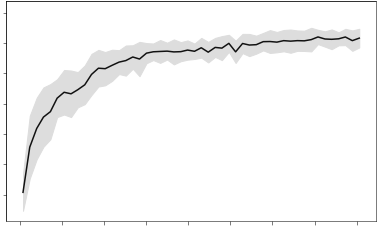



In [ ]:
random.seed(a=3)

# paramètres du test
tabou_min = 1
tabou_max = 40
nb_objets = 200

nb_test  = 100
iter_max = 20

# on affiche la barre de progression
nb_steps_bar = #À COMPLÉTER
bar = IntProgress(min=0, max=nb_steps_bar, layout={"width" : "100%"})
display(bar)

# pour stocker les résultats
moyennes   = []
deviations = []

random.seed(a=3)

# cette fois on boucle sur la taille de la liste tabou
#À COMPLÉTER

# on cache la barre de progression
bar.close()

# affichage de la courbe de moyenne
plt.plot(range(tabou_min, tabou_max), moyennes)

# affichage de la bande d'écart-type
plt.fill_between(range(tabou_min, tabou_max),
                 np.subtract(moyennes, deviations), # borne haute
                 np.add(moyennes, deviations),      # borne basse
                 alpha=.1)                          # transparence
plt.xlabel("taille de la liste tabou")
plt.ylabel("distance à la borne")
plt.title("Impact de la taille de la liste tabou sur la qualité des solutions")
plt.show()

Qu'observez-vous&nbsp;?

<em>À COMPLÉTER</em>

Cela ouvre des perspectives pour continuer les tests, et en tirer des conclusions sur les paramètres les plus efficaces de l'algorithme. Comment pourrait-on procéder&nbsp;?

<em>À COMPLÉTER</em>

Si on veut vérifier ça de manière automatique, comment pourrait-on procéder&nbsp;?

<em>À COMPLÉTER</em>

En tous cas, tout porte à croire que notre paramétrage de l'algorithme n'était pas optimal. On perdait en temps de calcul par rapport à la qualité de la solution générée.

## 3.3 Impact des paramètres d'instance

Mais finalement, on veut améliorer les performances sur ces instances difficiles, alors qu'on ne sait même pas ce qui les rend compliquées à résoudre. Du coup, la question qu'on peut se poser, c'est&nbsp;: qu'est-ce qui rend une instance difficile&nbsp;?

Pour commencer, on va jouer sur le nombre d'objets, c'est ce qu'il y a de plus simple à implémenter.


In [ ]:
random.seed(a=3)

# paramètres du test
objets_min   = 20
objets_max   = 320
objets_steps = 20
nb_test      = 200

taille_tabou = 5
iter_max     = taille_tabou*2

nb_steps_bar = #À COMPLÉTER

# on affiche la barre de progression
bar = IntProgress(min=0, max=nb_steps_bar, layout={"width" : "100%"})
display(bar)

# pour stocker les résultats
moyennes   = []
deviations = []

# on fait varier le nombre d'objets dans la génération aléatoire d'instances 
#À COMPLÉTER

# on cache la barre de progression
bar.close()

# affichage de la courbe de moyenne
plt.plot(range(objets_min, objets_max, objets_steps), moyennes)

# affichage de la bande d'écart-type
plt.fill_between(range(objets_min, objets_max, objets_steps),
                 np.subtract(moyennes, deviations), # borne haute
                 np.add(moyennes, deviations),      # borne basse
                 alpha=.1)                          # transparence
plt.ylim(top=100)
plt.xlabel("nombre d'objets disponibles")
plt.ylabel("distance à la borne")
plt.title("Impact du nombre d'objets sur la qualité des solutions")
plt.show()

Que pensez-vous de ces résultats&nbsp;? Comment les interprétez-vous&nbsp;?

<em>À COMPLÉTER</em>


## 3.4 Pour aller plus loin

Il y a encore beaucoup de choses qu'on pourrait étudier pour comprendre et surtout améliorer le fonctionnement de notre algorithme (sans compter les calculs de vous devriez peut-être refaire avec un plus grand nombre de tests par configuration). On n'a regardé que des paramètres seuls, pas la manière dont ils peuvent se combiner (ou très peu). Et puis on ne s'est pas du tout penchés sur le temps de calcul. Comme lorsqu'on étudiait la complexité théorique des algorithmes, mesurer le temps d'occupation CPU ne sera pas forcément pertinent. Quelle métrique vous semble avoir du sens&nbsp;?

<em>À COMPLÉTER</em>

En tous cas, ça nous a permis d'améliorer la qualité de la solution en affinant les paramètres de la recherche tabou pour renforcer la phase de diversification (qui ici semblait nous poser problème). Si on rencontrait des instances plus difficiles, que notre algorithme n'arrive pas à résoudre efficacement, quel que soit le paramétrage, que pourrions-nous faire&nbsp;?

<em>À COMPLÉTER</em>

Et puis une fois tout ce travail fait (et pas avant), on pourrait aussi regarder le multi-start. Qu'est-ce qui vous semble pertinent&nbsp;?

<em>À COMPLÉTER</em>


# 4 Conclusion

Ce Workshop est maintenant terminé, et on a une idée beaucoup plus précise du comportement de notre métaheuristique.



Et si on fait un peu attention, cette étude expérimentale qu'on a effectuée est organisée comme un [plan d'expériences](https://fr.wikipedia.org/wiki/Plan_d%27exp%C3%A9riences) (par exemple, le fait de considérer la recherche simple avant de pouvoir se pencher sur le multi-start, ou la définition d'un indicateur de qualité en premier lieu). Il faudra réfléchir à un plan similaire pour votre projet, de manière à ne pas perdre de temps (d'autant que les calculs sont plutôt longs). Par contre, ne poussez pas la démarche jusqu'à appliquer les principes mathématiques mentionnés dans le lien précédent, ce sont des outils rarement utilisés tel quel dans le domaine de l'évaluation d'algorithmes.


Vous avez maintenant toutes les armes pour, non seulement concevoir et implémenter une métaheuristique, mais aussi analyser son comportement et optimiser ses paramètres pour en tirer le meilleur.